# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.58KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

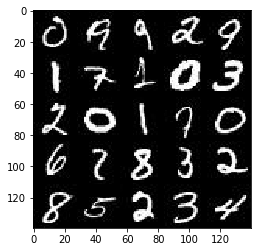

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

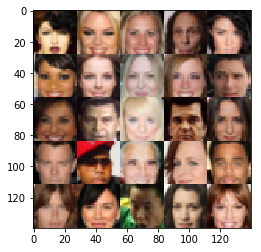

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                               name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None,z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learn_rate')

    return inputs_real, inputs_z,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [29]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha= 0.1
    stddev= 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        # input layer with image size(28*28*3)
        x1 = tf.layers.conv2d(images, 32, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        lrelu1 = tf.maximum(alpha * x1, x1)
        # Layer 1 out: 14x14x32
        
        # Layer 2: 14x14x32
        x2 = tf.layers.conv2d(lrelu1, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # Layer 2 out: 7x7x64
        
        x3 = tf.layers.conv2d(lrelu2, 128, 5, 2, padding='same',  kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # Layer 3 out: 4x4x128
        
        x4 = tf.layers.conv2d(lrelu3, 256, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn4 = tf.layers.batch_normalization(x4, training=True)
        lrelu4 = tf.maximum(alpha * bn4, bn4)
        # Layer 4 out: 2x2x256
        
        flattened = tf.reshape(lrelu4, (-1, 2*2*256))
        logits = tf.layers.dense(flattened, 1, kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.sigmoid(logits)
        
        return output, logits
        
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [30]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    stddev = 0.02
    # variable scope for generator
    with tf.variable_scope('generator', reuse=not is_train):
        #fake with fully connected
        # Layer 1 in: 7x7x256
        x1 = tf.layers.dense(z, 4 * 4 * 512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        #x1 = tf.layers.batch_normalization(layer_1, training=is_train)
        lrelu1 = tf.maximum(alpha * x1, x1)
        # Layer 1 out: 4x4x512
        
        x2 = tf.layers.conv2d_transpose(lrelu1, 128, 4, 1, padding='valid', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        # Layer 2 out: 8x8x128
        
        x3 = tf.layers.conv2d_transpose(lrelu2, 64, 5, 2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        # Layer 3 out: 16x16x64
        
        x4 = tf.layers.conv2d_transpose(lrelu3, 32, 5, 2, padding='same',kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        lrelu4 = tf.maximum(alpha * bn4, bn4)
        # Layer 4 out: 32x32x32
        
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 3, 1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        output = tf.tanh(logits)
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [31]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [32]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [33]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [34]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 6.2174... Generator Loss: 0.0032
Epoch 0/2... Discriminator Loss: 2.0194... Generator Loss: 0.1843
Epoch 0/2... Discriminator Loss: 0.9569... Generator Loss: 6.3979
Epoch 0/2... Discriminator Loss: 0.7984... Generator Loss: 0.9334


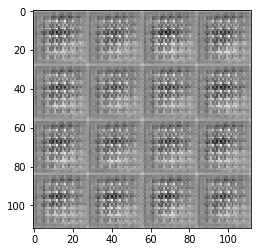

Epoch 0/2... Discriminator Loss: 0.2951... Generator Loss: 1.7897
Epoch 0/2... Discriminator Loss: 0.1446... Generator Loss: 2.4609
Epoch 0/2... Discriminator Loss: 0.2824... Generator Loss: 2.0811
Epoch 0/2... Discriminator Loss: 0.6972... Generator Loss: 1.7707
Epoch 0/2... Discriminator Loss: 1.3859... Generator Loss: 0.5337


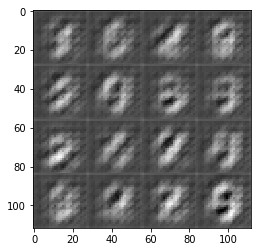

Epoch 0/2... Discriminator Loss: 2.2417... Generator Loss: 0.2233
Epoch 0/2... Discriminator Loss: 0.7337... Generator Loss: 2.1006
Epoch 0/2... Discriminator Loss: 1.0265... Generator Loss: 4.8786
Epoch 0/2... Discriminator Loss: 0.6634... Generator Loss: 1.0264
Epoch 0/2... Discriminator Loss: 0.6671... Generator Loss: 4.2351


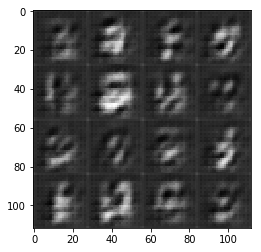

Epoch 0/2... Discriminator Loss: 0.7515... Generator Loss: 2.7842
Epoch 0/2... Discriminator Loss: 0.9489... Generator Loss: 1.6098
Epoch 0/2... Discriminator Loss: 0.6968... Generator Loss: 2.0843
Epoch 0/2... Discriminator Loss: 1.3928... Generator Loss: 0.4145
Epoch 0/2... Discriminator Loss: 1.1564... Generator Loss: 2.1408


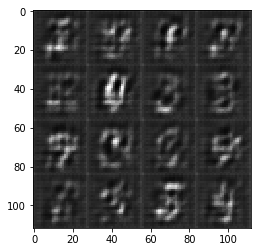

Epoch 0/2... Discriminator Loss: 1.3143... Generator Loss: 2.4907
Epoch 0/2... Discriminator Loss: 0.8140... Generator Loss: 1.8119
Epoch 0/2... Discriminator Loss: 1.1181... Generator Loss: 1.2373
Epoch 0/2... Discriminator Loss: 0.7949... Generator Loss: 1.1114
Epoch 0/2... Discriminator Loss: 0.7706... Generator Loss: 1.5518


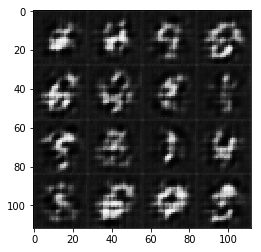

Epoch 0/2... Discriminator Loss: 0.5934... Generator Loss: 1.4677
Epoch 0/2... Discriminator Loss: 0.8877... Generator Loss: 1.6082
Epoch 0/2... Discriminator Loss: 0.5552... Generator Loss: 2.2589
Epoch 0/2... Discriminator Loss: 0.7840... Generator Loss: 0.8715
Epoch 0/2... Discriminator Loss: 0.7579... Generator Loss: 1.0463


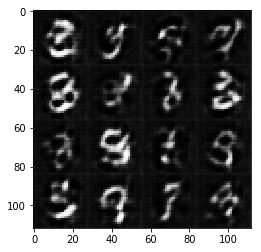

Epoch 0/2... Discriminator Loss: 0.9350... Generator Loss: 0.8029
Epoch 0/2... Discriminator Loss: 0.6162... Generator Loss: 1.3817
Epoch 0/2... Discriminator Loss: 0.8263... Generator Loss: 0.8841
Epoch 0/2... Discriminator Loss: 0.7361... Generator Loss: 1.0163
Epoch 0/2... Discriminator Loss: 0.5521... Generator Loss: 1.8977


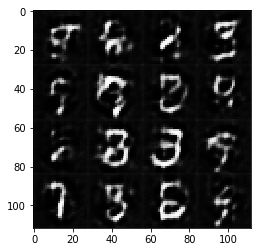

Epoch 0/2... Discriminator Loss: 0.6589... Generator Loss: 1.2223
Epoch 0/2... Discriminator Loss: 0.8750... Generator Loss: 0.8767
Epoch 0/2... Discriminator Loss: 1.6139... Generator Loss: 3.2760
Epoch 0/2... Discriminator Loss: 0.6788... Generator Loss: 1.4233
Epoch 0/2... Discriminator Loss: 0.7428... Generator Loss: 1.3550


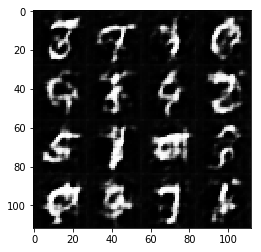

Epoch 0/2... Discriminator Loss: 0.8366... Generator Loss: 1.2030
Epoch 0/2... Discriminator Loss: 0.9884... Generator Loss: 0.6543
Epoch 0/2... Discriminator Loss: 1.1570... Generator Loss: 0.5732
Epoch 0/2... Discriminator Loss: 1.1448... Generator Loss: 2.9259
Epoch 0/2... Discriminator Loss: 1.0437... Generator Loss: 0.6256


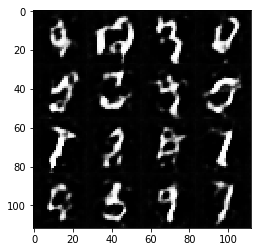

Epoch 0/2... Discriminator Loss: 0.7803... Generator Loss: 1.5272
Epoch 0/2... Discriminator Loss: 0.8251... Generator Loss: 1.5278
Epoch 0/2... Discriminator Loss: 0.7541... Generator Loss: 1.4198
Epoch 0/2... Discriminator Loss: 0.7655... Generator Loss: 0.9976
Epoch 0/2... Discriminator Loss: 0.9818... Generator Loss: 0.6673


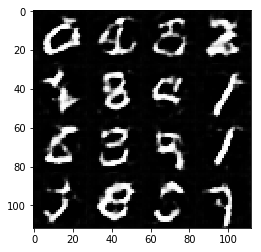

Epoch 0/2... Discriminator Loss: 1.1496... Generator Loss: 0.5214
Epoch 0/2... Discriminator Loss: 0.8303... Generator Loss: 0.8823
Epoch 0/2... Discriminator Loss: 0.6634... Generator Loss: 1.9183
Epoch 0/2... Discriminator Loss: 0.6577... Generator Loss: 1.7701
Epoch 0/2... Discriminator Loss: 3.3489... Generator Loss: 0.0727


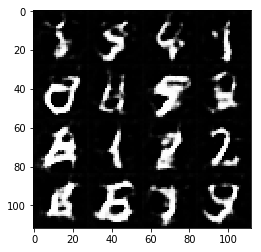

Epoch 0/2... Discriminator Loss: 0.8694... Generator Loss: 1.0371
Epoch 0/2... Discriminator Loss: 0.9390... Generator Loss: 0.8554
Epoch 0/2... Discriminator Loss: 0.7146... Generator Loss: 1.3507
Epoch 0/2... Discriminator Loss: 0.8346... Generator Loss: 1.0740
Epoch 0/2... Discriminator Loss: 0.9420... Generator Loss: 0.6916


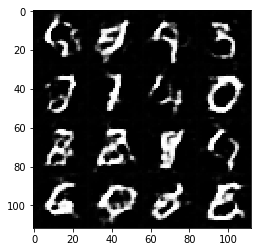

Epoch 0/2... Discriminator Loss: 1.2962... Generator Loss: 0.4041
Epoch 0/2... Discriminator Loss: 1.1979... Generator Loss: 0.6039
Epoch 0/2... Discriminator Loss: 1.0400... Generator Loss: 0.7126
Epoch 0/2... Discriminator Loss: 0.7629... Generator Loss: 1.7780
Epoch 0/2... Discriminator Loss: 0.7876... Generator Loss: 1.1984


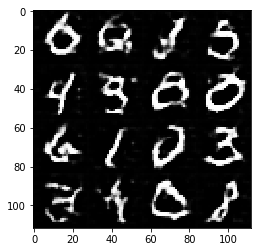

Epoch 0/2... Discriminator Loss: 0.8615... Generator Loss: 0.7584
Epoch 0/2... Discriminator Loss: 0.7125... Generator Loss: 1.8871
Epoch 0/2... Discriminator Loss: 0.9127... Generator Loss: 0.8266
Epoch 0/2... Discriminator Loss: 1.3330... Generator Loss: 0.4175
Epoch 0/2... Discriminator Loss: 0.9414... Generator Loss: 1.0643


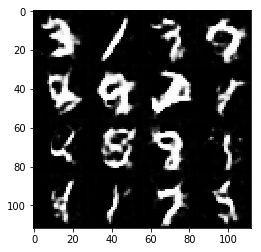

Epoch 0/2... Discriminator Loss: 0.6300... Generator Loss: 1.6651
Epoch 0/2... Discriminator Loss: 0.7184... Generator Loss: 1.1256
Epoch 0/2... Discriminator Loss: 0.9455... Generator Loss: 0.7416
Epoch 0/2... Discriminator Loss: 0.7462... Generator Loss: 1.3643
Epoch 0/2... Discriminator Loss: 0.8444... Generator Loss: 1.1309


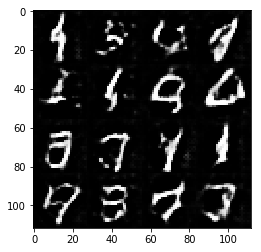

Epoch 0/2... Discriminator Loss: 0.8791... Generator Loss: 2.2941
Epoch 0/2... Discriminator Loss: 1.0109... Generator Loss: 0.7641
Epoch 0/2... Discriminator Loss: 0.8955... Generator Loss: 1.3269
Epoch 0/2... Discriminator Loss: 0.9357... Generator Loss: 0.9427
Epoch 0/2... Discriminator Loss: 1.0461... Generator Loss: 0.8731


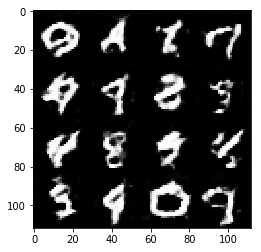

Epoch 0/2... Discriminator Loss: 1.1638... Generator Loss: 0.5100
Epoch 0/2... Discriminator Loss: 0.8783... Generator Loss: 0.7434
Epoch 0/2... Discriminator Loss: 1.8202... Generator Loss: 3.4903
Epoch 0/2... Discriminator Loss: 1.1074... Generator Loss: 0.6405
Epoch 0/2... Discriminator Loss: 1.1225... Generator Loss: 1.6756


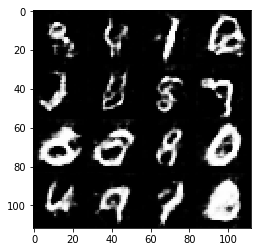

Epoch 0/2... Discriminator Loss: 1.1318... Generator Loss: 0.5563
Epoch 0/2... Discriminator Loss: 0.8534... Generator Loss: 1.1559
Epoch 0/2... Discriminator Loss: 0.9385... Generator Loss: 0.7371
Epoch 0/2... Discriminator Loss: 0.8422... Generator Loss: 1.2445
Epoch 0/2... Discriminator Loss: 1.1406... Generator Loss: 0.6405


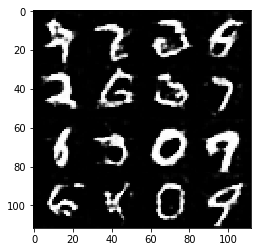

Epoch 0/2... Discriminator Loss: 0.9123... Generator Loss: 1.4169
Epoch 0/2... Discriminator Loss: 1.6729... Generator Loss: 0.2724
Epoch 0/2... Discriminator Loss: 0.9917... Generator Loss: 1.6801
Epoch 0/2... Discriminator Loss: 0.9304... Generator Loss: 1.3341
Epoch 1/2... Discriminator Loss: 0.6059... Generator Loss: 1.7561


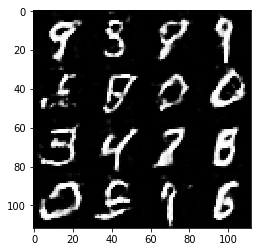

Epoch 1/2... Discriminator Loss: 1.3824... Generator Loss: 0.4267
Epoch 1/2... Discriminator Loss: 1.0706... Generator Loss: 0.6388
Epoch 1/2... Discriminator Loss: 0.9985... Generator Loss: 0.6312
Epoch 1/2... Discriminator Loss: 0.8701... Generator Loss: 1.4186
Epoch 1/2... Discriminator Loss: 0.8019... Generator Loss: 1.1480


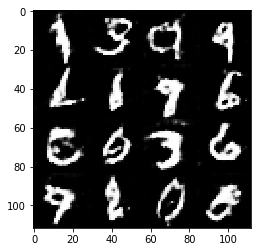

Epoch 1/2... Discriminator Loss: 0.8884... Generator Loss: 2.0498
Epoch 1/2... Discriminator Loss: 1.2462... Generator Loss: 2.0918
Epoch 1/2... Discriminator Loss: 0.8011... Generator Loss: 1.1528
Epoch 1/2... Discriminator Loss: 0.9388... Generator Loss: 1.3722
Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 1.2888


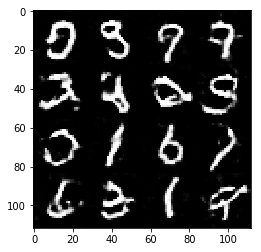

Epoch 1/2... Discriminator Loss: 1.0059... Generator Loss: 1.0158
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 1.0216
Epoch 1/2... Discriminator Loss: 1.5488... Generator Loss: 2.1799
Epoch 1/2... Discriminator Loss: 0.9239... Generator Loss: 1.1911
Epoch 1/2... Discriminator Loss: 0.9054... Generator Loss: 0.9933


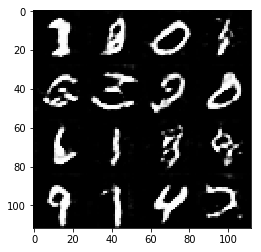

Epoch 1/2... Discriminator Loss: 0.9015... Generator Loss: 0.9583
Epoch 1/2... Discriminator Loss: 0.9326... Generator Loss: 0.7521
Epoch 1/2... Discriminator Loss: 1.2370... Generator Loss: 2.1242
Epoch 1/2... Discriminator Loss: 0.9984... Generator Loss: 0.7570
Epoch 1/2... Discriminator Loss: 1.0646... Generator Loss: 0.6118


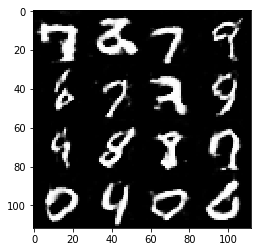

Epoch 1/2... Discriminator Loss: 1.0548... Generator Loss: 0.6000
Epoch 1/2... Discriminator Loss: 0.9343... Generator Loss: 1.8397
Epoch 1/2... Discriminator Loss: 1.1083... Generator Loss: 2.7399
Epoch 1/2... Discriminator Loss: 1.0337... Generator Loss: 1.0293
Epoch 1/2... Discriminator Loss: 0.9503... Generator Loss: 0.8949


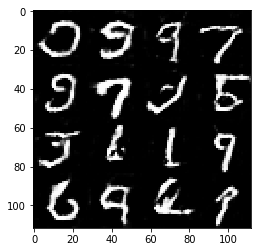

Epoch 1/2... Discriminator Loss: 0.8843... Generator Loss: 0.8839
Epoch 1/2... Discriminator Loss: 1.8880... Generator Loss: 0.2201
Epoch 1/2... Discriminator Loss: 1.0342... Generator Loss: 0.6665
Epoch 1/2... Discriminator Loss: 0.9309... Generator Loss: 1.2075
Epoch 1/2... Discriminator Loss: 1.0198... Generator Loss: 0.8378


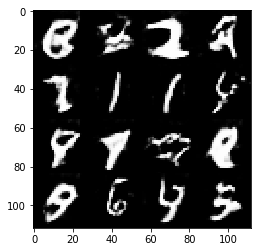

Epoch 1/2... Discriminator Loss: 1.0507... Generator Loss: 2.1168
Epoch 1/2... Discriminator Loss: 0.8349... Generator Loss: 1.2203
Epoch 1/2... Discriminator Loss: 1.2647... Generator Loss: 0.5164
Epoch 1/2... Discriminator Loss: 1.1178... Generator Loss: 0.6177
Epoch 1/2... Discriminator Loss: 0.7124... Generator Loss: 1.2500


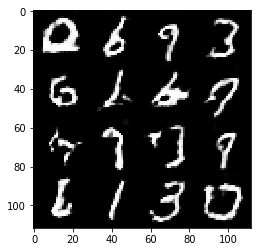

Epoch 1/2... Discriminator Loss: 1.0390... Generator Loss: 0.5906
Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 2.2352
Epoch 1/2... Discriminator Loss: 1.0634... Generator Loss: 1.5101
Epoch 1/2... Discriminator Loss: 0.9037... Generator Loss: 0.9812
Epoch 1/2... Discriminator Loss: 1.4789... Generator Loss: 0.3714


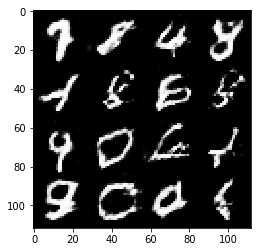

Epoch 1/2... Discriminator Loss: 0.7627... Generator Loss: 1.1206
Epoch 1/2... Discriminator Loss: 0.7226... Generator Loss: 1.4276
Epoch 1/2... Discriminator Loss: 0.8704... Generator Loss: 0.9467
Epoch 1/2... Discriminator Loss: 1.2349... Generator Loss: 0.4671
Epoch 1/2... Discriminator Loss: 0.8083... Generator Loss: 0.9754


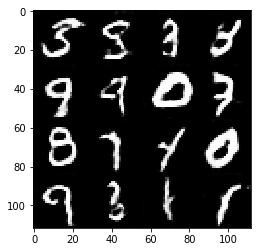

Epoch 1/2... Discriminator Loss: 0.7576... Generator Loss: 1.4094
Epoch 1/2... Discriminator Loss: 0.8464... Generator Loss: 1.1799
Epoch 1/2... Discriminator Loss: 0.9811... Generator Loss: 0.7085
Epoch 1/2... Discriminator Loss: 0.8645... Generator Loss: 1.9704
Epoch 1/2... Discriminator Loss: 1.1026... Generator Loss: 2.2842


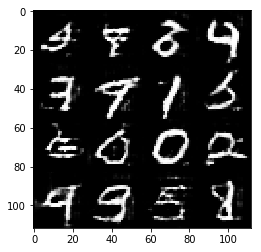

Epoch 1/2... Discriminator Loss: 0.8546... Generator Loss: 1.0039
Epoch 1/2... Discriminator Loss: 1.1317... Generator Loss: 0.5914
Epoch 1/2... Discriminator Loss: 1.6649... Generator Loss: 0.3103
Epoch 1/2... Discriminator Loss: 0.8897... Generator Loss: 1.0342
Epoch 1/2... Discriminator Loss: 0.6957... Generator Loss: 1.3099


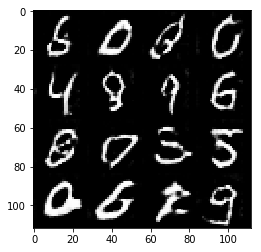

Epoch 1/2... Discriminator Loss: 0.9194... Generator Loss: 1.2999
Epoch 1/2... Discriminator Loss: 1.3030... Generator Loss: 0.4622
Epoch 1/2... Discriminator Loss: 1.3021... Generator Loss: 0.4170
Epoch 1/2... Discriminator Loss: 0.6305... Generator Loss: 1.3815
Epoch 1/2... Discriminator Loss: 1.0120... Generator Loss: 2.1892


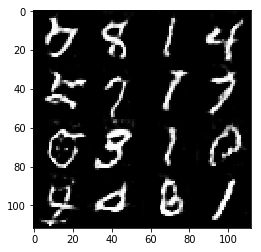

Epoch 1/2... Discriminator Loss: 0.9577... Generator Loss: 0.8894
Epoch 1/2... Discriminator Loss: 0.9366... Generator Loss: 1.2266
Epoch 1/2... Discriminator Loss: 0.9125... Generator Loss: 1.1443
Epoch 1/2... Discriminator Loss: 0.7807... Generator Loss: 1.0263
Epoch 1/2... Discriminator Loss: 0.8923... Generator Loss: 1.0543


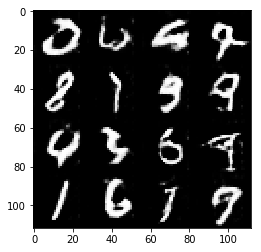

Epoch 1/2... Discriminator Loss: 0.8679... Generator Loss: 1.3565
Epoch 1/2... Discriminator Loss: 1.2422... Generator Loss: 0.4406
Epoch 1/2... Discriminator Loss: 1.2036... Generator Loss: 2.3879
Epoch 1/2... Discriminator Loss: 1.0116... Generator Loss: 1.8299
Epoch 1/2... Discriminator Loss: 0.8213... Generator Loss: 1.5673


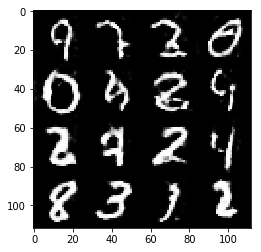

Epoch 1/2... Discriminator Loss: 0.9653... Generator Loss: 0.7235
Epoch 1/2... Discriminator Loss: 0.9654... Generator Loss: 1.5017
Epoch 1/2... Discriminator Loss: 0.6334... Generator Loss: 1.2905
Epoch 1/2... Discriminator Loss: 1.1706... Generator Loss: 0.5154
Epoch 1/2... Discriminator Loss: 1.2946... Generator Loss: 0.5311


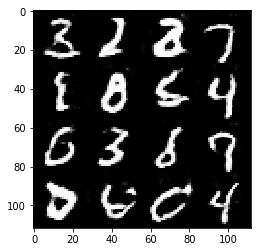

Epoch 1/2... Discriminator Loss: 0.8921... Generator Loss: 0.8265
Epoch 1/2... Discriminator Loss: 0.8776... Generator Loss: 0.9710
Epoch 1/2... Discriminator Loss: 1.0665... Generator Loss: 0.5747
Epoch 1/2... Discriminator Loss: 0.9048... Generator Loss: 1.0018
Epoch 1/2... Discriminator Loss: 0.8584... Generator Loss: 1.1895


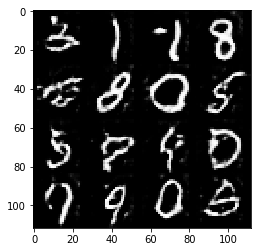

Epoch 1/2... Discriminator Loss: 0.5375... Generator Loss: 1.4802
Epoch 1/2... Discriminator Loss: 0.8814... Generator Loss: 0.8529
Epoch 1/2... Discriminator Loss: 0.8573... Generator Loss: 1.2823
Epoch 1/2... Discriminator Loss: 0.7764... Generator Loss: 0.9278
Epoch 1/2... Discriminator Loss: 0.9645... Generator Loss: 0.7820


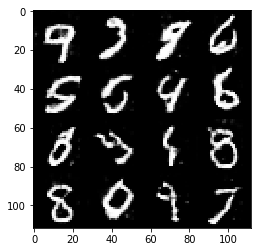

Epoch 1/2... Discriminator Loss: 1.3299... Generator Loss: 2.5064
Epoch 1/2... Discriminator Loss: 0.7532... Generator Loss: 1.0157
Epoch 1/2... Discriminator Loss: 0.7452... Generator Loss: 1.1504
Epoch 1/2... Discriminator Loss: 0.9348... Generator Loss: 0.8044
Epoch 1/2... Discriminator Loss: 0.9038... Generator Loss: 0.6698


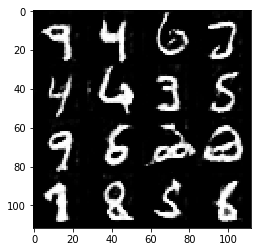

Epoch 1/2... Discriminator Loss: 0.8009... Generator Loss: 1.2945
Epoch 1/2... Discriminator Loss: 1.4197... Generator Loss: 0.4465
Epoch 1/2... Discriminator Loss: 2.0242... Generator Loss: 0.1881


In [27]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 2.1875... Generator Loss: 0.1463
Epoch 0/1... Discriminator Loss: 0.9543... Generator Loss: 0.7037
Epoch 0/1... Discriminator Loss: 0.5478... Generator Loss: 3.1897
Epoch 0/1... Discriminator Loss: 0.3959... Generator Loss: 2.9439


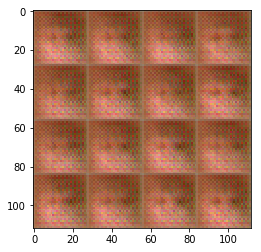

Epoch 0/1... Discriminator Loss: 0.5983... Generator Loss: 3.0525
Epoch 0/1... Discriminator Loss: 0.9923... Generator Loss: 0.9955
Epoch 0/1... Discriminator Loss: 1.5378... Generator Loss: 0.6909
Epoch 0/1... Discriminator Loss: 1.5099... Generator Loss: 0.6107
Epoch 0/1... Discriminator Loss: 1.0638... Generator Loss: 1.0144


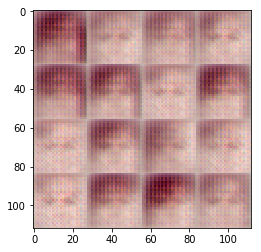

Epoch 0/1... Discriminator Loss: 0.6410... Generator Loss: 1.4348
Epoch 0/1... Discriminator Loss: 1.3191... Generator Loss: 0.7217
Epoch 0/1... Discriminator Loss: 0.8892... Generator Loss: 1.0621
Epoch 0/1... Discriminator Loss: 1.2372... Generator Loss: 0.7811
Epoch 0/1... Discriminator Loss: 1.0482... Generator Loss: 1.0573


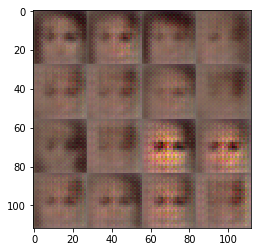

Epoch 0/1... Discriminator Loss: 0.4297... Generator Loss: 1.7842
Epoch 0/1... Discriminator Loss: 1.1654... Generator Loss: 0.7365
Epoch 0/1... Discriminator Loss: 1.8572... Generator Loss: 2.2553
Epoch 0/1... Discriminator Loss: 0.6662... Generator Loss: 2.5758
Epoch 0/1... Discriminator Loss: 0.8805... Generator Loss: 1.2335


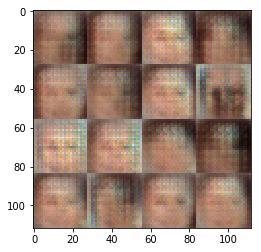

Epoch 0/1... Discriminator Loss: 1.3604... Generator Loss: 0.9919
Epoch 0/1... Discriminator Loss: 0.8598... Generator Loss: 0.9629
Epoch 0/1... Discriminator Loss: 1.1183... Generator Loss: 0.9544
Epoch 0/1... Discriminator Loss: 0.9838... Generator Loss: 1.2902
Epoch 0/1... Discriminator Loss: 0.9422... Generator Loss: 1.4712


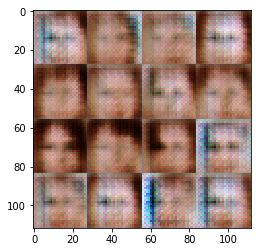

Epoch 0/1... Discriminator Loss: 0.7657... Generator Loss: 1.2437
Epoch 0/1... Discriminator Loss: 1.0991... Generator Loss: 1.0582
Epoch 0/1... Discriminator Loss: 1.3361... Generator Loss: 0.4373
Epoch 0/1... Discriminator Loss: 0.8582... Generator Loss: 1.1405
Epoch 0/1... Discriminator Loss: 0.8561... Generator Loss: 1.3098


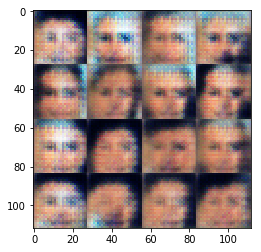

Epoch 0/1... Discriminator Loss: 1.0090... Generator Loss: 1.0335
Epoch 0/1... Discriminator Loss: 1.2864... Generator Loss: 1.2009
Epoch 0/1... Discriminator Loss: 1.0137... Generator Loss: 0.9768
Epoch 0/1... Discriminator Loss: 0.9699... Generator Loss: 1.2941
Epoch 0/1... Discriminator Loss: 0.8975... Generator Loss: 1.0005


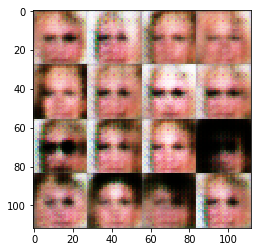

Epoch 0/1... Discriminator Loss: 0.8837... Generator Loss: 0.9600
Epoch 0/1... Discriminator Loss: 0.7061... Generator Loss: 1.6785
Epoch 0/1... Discriminator Loss: 1.0681... Generator Loss: 0.7072
Epoch 0/1... Discriminator Loss: 1.1881... Generator Loss: 0.9352
Epoch 0/1... Discriminator Loss: 1.3099... Generator Loss: 0.6955


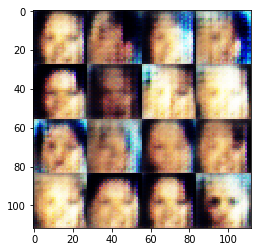

Epoch 0/1... Discriminator Loss: 0.7015... Generator Loss: 1.2430
Epoch 0/1... Discriminator Loss: 1.5819... Generator Loss: 0.3422
Epoch 0/1... Discriminator Loss: 1.1301... Generator Loss: 2.8486
Epoch 0/1... Discriminator Loss: 0.5040... Generator Loss: 1.8461
Epoch 0/1... Discriminator Loss: 0.9419... Generator Loss: 1.0449


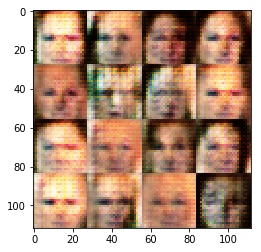

Epoch 0/1... Discriminator Loss: 1.0220... Generator Loss: 0.8192
Epoch 0/1... Discriminator Loss: 0.6913... Generator Loss: 1.4754
Epoch 0/1... Discriminator Loss: 0.9930... Generator Loss: 0.7638
Epoch 0/1... Discriminator Loss: 0.7053... Generator Loss: 1.1529
Epoch 0/1... Discriminator Loss: 1.5630... Generator Loss: 0.3256


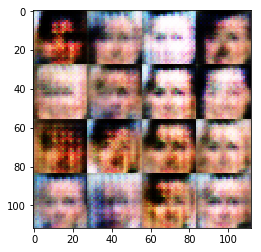

Epoch 0/1... Discriminator Loss: 1.2348... Generator Loss: 0.4937
Epoch 0/1... Discriminator Loss: 1.0642... Generator Loss: 1.3173
Epoch 0/1... Discriminator Loss: 0.7579... Generator Loss: 1.2348
Epoch 0/1... Discriminator Loss: 0.8637... Generator Loss: 1.0321
Epoch 0/1... Discriminator Loss: 0.7266... Generator Loss: 1.3261


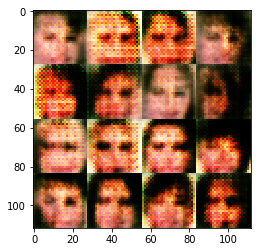

Epoch 0/1... Discriminator Loss: 1.8409... Generator Loss: 0.2401
Epoch 0/1... Discriminator Loss: 1.2987... Generator Loss: 1.5610
Epoch 0/1... Discriminator Loss: 0.7270... Generator Loss: 1.4779
Epoch 0/1... Discriminator Loss: 1.3199... Generator Loss: 0.6731
Epoch 0/1... Discriminator Loss: 0.8763... Generator Loss: 0.7167


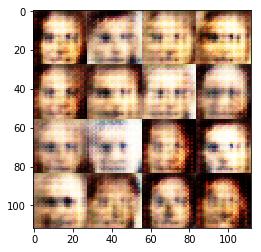

Epoch 0/1... Discriminator Loss: 1.3816... Generator Loss: 1.9608
Epoch 0/1... Discriminator Loss: 0.8798... Generator Loss: 0.9887
Epoch 0/1... Discriminator Loss: 0.6723... Generator Loss: 1.4495
Epoch 0/1... Discriminator Loss: 1.9170... Generator Loss: 2.6747
Epoch 0/1... Discriminator Loss: 0.9855... Generator Loss: 0.8929


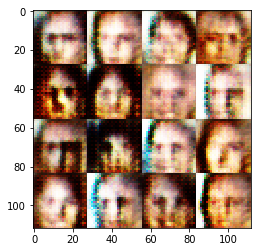

Epoch 0/1... Discriminator Loss: 0.8559... Generator Loss: 1.1978
Epoch 0/1... Discriminator Loss: 1.1180... Generator Loss: 0.5684
Epoch 0/1... Discriminator Loss: 1.3654... Generator Loss: 0.4739
Epoch 0/1... Discriminator Loss: 1.1504... Generator Loss: 0.8847
Epoch 0/1... Discriminator Loss: 0.8811... Generator Loss: 1.2021


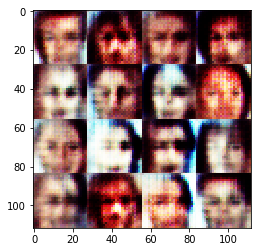

Epoch 0/1... Discriminator Loss: 0.8806... Generator Loss: 1.2206
Epoch 0/1... Discriminator Loss: 0.8743... Generator Loss: 1.3417
Epoch 0/1... Discriminator Loss: 0.9359... Generator Loss: 0.8268
Epoch 0/1... Discriminator Loss: 0.6482... Generator Loss: 1.2607
Epoch 0/1... Discriminator Loss: 0.6704... Generator Loss: 1.0630


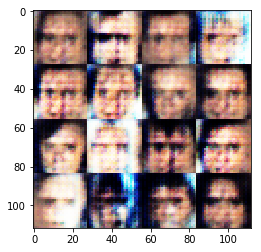

Epoch 0/1... Discriminator Loss: 0.8053... Generator Loss: 0.9104
Epoch 0/1... Discriminator Loss: 0.6829... Generator Loss: 1.6974
Epoch 0/1... Discriminator Loss: 1.1009... Generator Loss: 0.8755
Epoch 0/1... Discriminator Loss: 1.3582... Generator Loss: 0.5398
Epoch 0/1... Discriminator Loss: 1.1115... Generator Loss: 0.6275


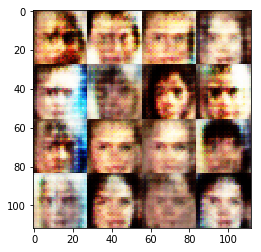

Epoch 0/1... Discriminator Loss: 0.9395... Generator Loss: 0.8055
Epoch 0/1... Discriminator Loss: 0.9171... Generator Loss: 1.0284
Epoch 0/1... Discriminator Loss: 1.3504... Generator Loss: 0.7340
Epoch 0/1... Discriminator Loss: 0.7975... Generator Loss: 1.0506
Epoch 0/1... Discriminator Loss: 0.8045... Generator Loss: 0.9018


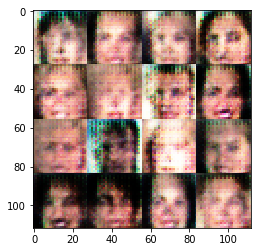

Epoch 0/1... Discriminator Loss: 1.7359... Generator Loss: 0.2728
Epoch 0/1... Discriminator Loss: 0.6528... Generator Loss: 1.5052
Epoch 0/1... Discriminator Loss: 0.7730... Generator Loss: 1.0484
Epoch 0/1... Discriminator Loss: 1.0904... Generator Loss: 1.0444
Epoch 0/1... Discriminator Loss: 1.5397... Generator Loss: 2.2565


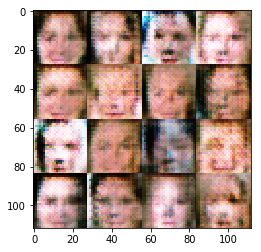

Epoch 0/1... Discriminator Loss: 0.7026... Generator Loss: 1.1038
Epoch 0/1... Discriminator Loss: 0.8841... Generator Loss: 1.3344
Epoch 0/1... Discriminator Loss: 0.9299... Generator Loss: 1.2125
Epoch 0/1... Discriminator Loss: 1.1689... Generator Loss: 0.6885
Epoch 0/1... Discriminator Loss: 0.8374... Generator Loss: 1.4324


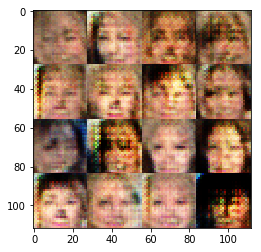

Epoch 0/1... Discriminator Loss: 0.8223... Generator Loss: 1.5325
Epoch 0/1... Discriminator Loss: 1.2007... Generator Loss: 2.2461
Epoch 0/1... Discriminator Loss: 1.1589... Generator Loss: 0.8771
Epoch 0/1... Discriminator Loss: 0.8450... Generator Loss: 1.5624
Epoch 0/1... Discriminator Loss: 0.7879... Generator Loss: 1.4286


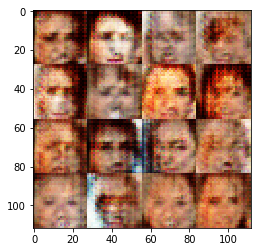

Epoch 0/1... Discriminator Loss: 1.0186... Generator Loss: 0.9997
Epoch 0/1... Discriminator Loss: 0.9967... Generator Loss: 0.7446
Epoch 0/1... Discriminator Loss: 1.1836... Generator Loss: 1.1962
Epoch 0/1... Discriminator Loss: 0.9776... Generator Loss: 0.8414
Epoch 0/1... Discriminator Loss: 0.8510... Generator Loss: 1.8608


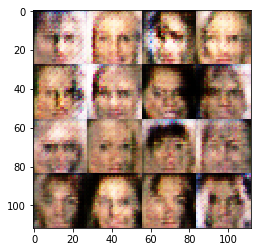

Epoch 0/1... Discriminator Loss: 1.7023... Generator Loss: 0.3724
Epoch 0/1... Discriminator Loss: 1.0745... Generator Loss: 0.8213
Epoch 0/1... Discriminator Loss: 1.1385... Generator Loss: 0.8123
Epoch 0/1... Discriminator Loss: 0.6828... Generator Loss: 1.2939
Epoch 0/1... Discriminator Loss: 0.7913... Generator Loss: 1.0814


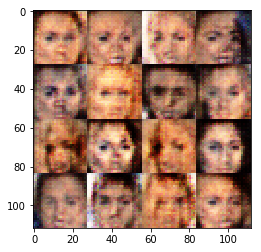

Epoch 0/1... Discriminator Loss: 1.1542... Generator Loss: 0.9743
Epoch 0/1... Discriminator Loss: 0.8084... Generator Loss: 1.1563
Epoch 0/1... Discriminator Loss: 0.8002... Generator Loss: 0.9121
Epoch 0/1... Discriminator Loss: 1.0563... Generator Loss: 0.6020
Epoch 0/1... Discriminator Loss: 1.1017... Generator Loss: 1.4813


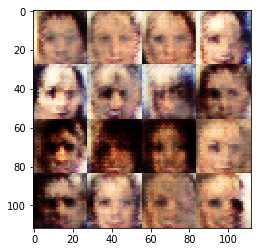

Epoch 0/1... Discriminator Loss: 1.3946... Generator Loss: 1.5757
Epoch 0/1... Discriminator Loss: 1.1750... Generator Loss: 0.5909
Epoch 0/1... Discriminator Loss: 0.8156... Generator Loss: 1.3809
Epoch 0/1... Discriminator Loss: 1.3031... Generator Loss: 0.8447
Epoch 0/1... Discriminator Loss: 1.3629... Generator Loss: 0.4379


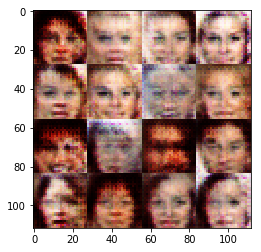

Epoch 0/1... Discriminator Loss: 1.0029... Generator Loss: 0.7860
Epoch 0/1... Discriminator Loss: 1.0553... Generator Loss: 0.7380
Epoch 0/1... Discriminator Loss: 0.9254... Generator Loss: 1.2464
Epoch 0/1... Discriminator Loss: 0.8148... Generator Loss: 1.0772
Epoch 0/1... Discriminator Loss: 0.9905... Generator Loss: 0.9384


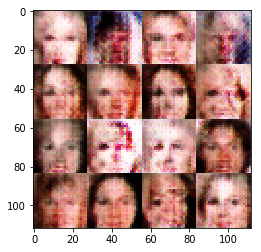

Epoch 0/1... Discriminator Loss: 1.0685... Generator Loss: 0.6833
Epoch 0/1... Discriminator Loss: 1.0339... Generator Loss: 0.6995
Epoch 0/1... Discriminator Loss: 1.6835... Generator Loss: 0.3039
Epoch 0/1... Discriminator Loss: 1.2753... Generator Loss: 0.6168
Epoch 0/1... Discriminator Loss: 1.0375... Generator Loss: 0.6633


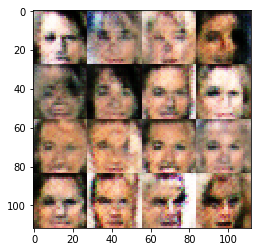

Epoch 0/1... Discriminator Loss: 1.1190... Generator Loss: 2.2554
Epoch 0/1... Discriminator Loss: 1.0095... Generator Loss: 0.9184
Epoch 0/1... Discriminator Loss: 0.9975... Generator Loss: 1.0748
Epoch 0/1... Discriminator Loss: 1.2020... Generator Loss: 1.9364
Epoch 0/1... Discriminator Loss: 0.8675... Generator Loss: 1.2357


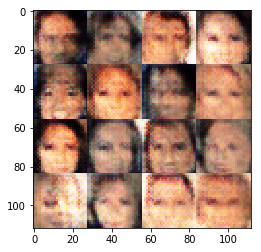

Epoch 0/1... Discriminator Loss: 0.9051... Generator Loss: 1.1878
Epoch 0/1... Discriminator Loss: 1.0581... Generator Loss: 1.2858
Epoch 0/1... Discriminator Loss: 0.9429... Generator Loss: 1.1568
Epoch 0/1... Discriminator Loss: 1.2921... Generator Loss: 0.7065
Epoch 0/1... Discriminator Loss: 1.0628... Generator Loss: 0.7322


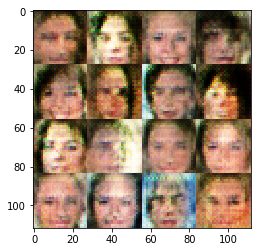

Epoch 0/1... Discriminator Loss: 0.9969... Generator Loss: 0.8583
Epoch 0/1... Discriminator Loss: 1.0474... Generator Loss: 0.7525
Epoch 0/1... Discriminator Loss: 1.0933... Generator Loss: 0.8528
Epoch 0/1... Discriminator Loss: 1.0510... Generator Loss: 0.6984
Epoch 0/1... Discriminator Loss: 1.0860... Generator Loss: 1.0353


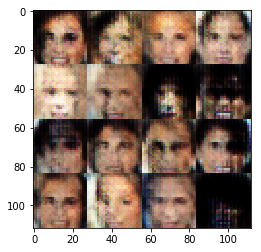

Epoch 0/1... Discriminator Loss: 0.9230... Generator Loss: 0.9278
Epoch 0/1... Discriminator Loss: 0.9861... Generator Loss: 0.7817
Epoch 0/1... Discriminator Loss: 0.9245... Generator Loss: 1.1793
Epoch 0/1... Discriminator Loss: 1.2739... Generator Loss: 0.5024
Epoch 0/1... Discriminator Loss: 1.1794... Generator Loss: 0.8734


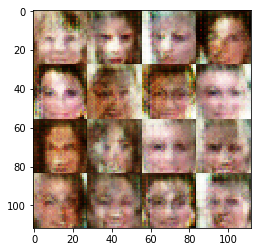

Epoch 0/1... Discriminator Loss: 0.7950... Generator Loss: 1.7850
Epoch 0/1... Discriminator Loss: 0.8368... Generator Loss: 0.9886
Epoch 0/1... Discriminator Loss: 0.8835... Generator Loss: 0.9602
Epoch 0/1... Discriminator Loss: 1.3130... Generator Loss: 0.4519
Epoch 0/1... Discriminator Loss: 1.1622... Generator Loss: 0.7291


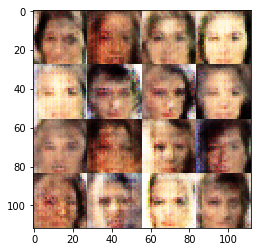

Epoch 0/1... Discriminator Loss: 1.1979... Generator Loss: 0.5343
Epoch 0/1... Discriminator Loss: 0.9697... Generator Loss: 1.1693
Epoch 0/1... Discriminator Loss: 0.9737... Generator Loss: 1.0950
Epoch 0/1... Discriminator Loss: 1.1000... Generator Loss: 0.6051
Epoch 0/1... Discriminator Loss: 0.9843... Generator Loss: 1.0415


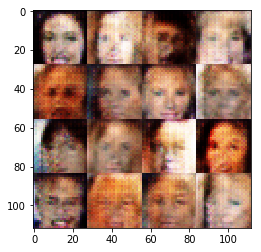

Epoch 0/1... Discriminator Loss: 0.8047... Generator Loss: 1.0234
Epoch 0/1... Discriminator Loss: 0.8450... Generator Loss: 1.1308
Epoch 0/1... Discriminator Loss: 0.8354... Generator Loss: 0.8623
Epoch 0/1... Discriminator Loss: 1.1878... Generator Loss: 0.5977
Epoch 0/1... Discriminator Loss: 0.7157... Generator Loss: 1.5525


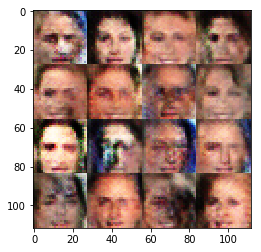

Epoch 0/1... Discriminator Loss: 0.8675... Generator Loss: 0.8839
Epoch 0/1... Discriminator Loss: 0.8215... Generator Loss: 1.0456
Epoch 0/1... Discriminator Loss: 1.2358... Generator Loss: 0.6736
Epoch 0/1... Discriminator Loss: 1.1134... Generator Loss: 0.6930
Epoch 0/1... Discriminator Loss: 1.1155... Generator Loss: 1.0092


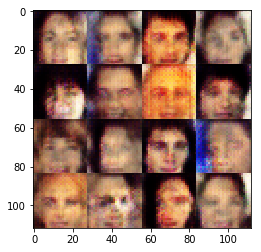

Epoch 0/1... Discriminator Loss: 0.8502... Generator Loss: 1.4333
Epoch 0/1... Discriminator Loss: 1.3111... Generator Loss: 1.8137
Epoch 0/1... Discriminator Loss: 1.0940... Generator Loss: 0.8221
Epoch 0/1... Discriminator Loss: 0.9598... Generator Loss: 0.9817
Epoch 0/1... Discriminator Loss: 0.7496... Generator Loss: 1.6934


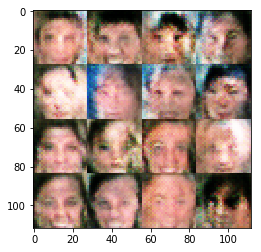

Epoch 0/1... Discriminator Loss: 1.1159... Generator Loss: 0.7114
Epoch 0/1... Discriminator Loss: 1.1303... Generator Loss: 0.9058
Epoch 0/1... Discriminator Loss: 1.0636... Generator Loss: 0.7591
Epoch 0/1... Discriminator Loss: 1.0276... Generator Loss: 0.7729
Epoch 0/1... Discriminator Loss: 0.9734... Generator Loss: 0.7330


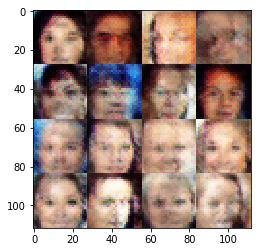

Epoch 0/1... Discriminator Loss: 0.7883... Generator Loss: 1.0444
Epoch 0/1... Discriminator Loss: 1.0493... Generator Loss: 0.7140
Epoch 0/1... Discriminator Loss: 0.8534... Generator Loss: 1.1864
Epoch 0/1... Discriminator Loss: 1.0715... Generator Loss: 0.7546
Epoch 0/1... Discriminator Loss: 0.9237... Generator Loss: 0.8983


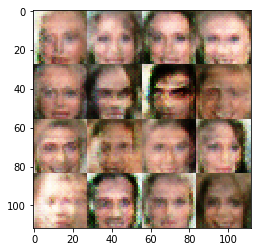

Epoch 0/1... Discriminator Loss: 1.2730... Generator Loss: 0.5559
Epoch 0/1... Discriminator Loss: 0.8111... Generator Loss: 0.9448
Epoch 0/1... Discriminator Loss: 0.7740... Generator Loss: 1.4685
Epoch 0/1... Discriminator Loss: 1.1464... Generator Loss: 0.7425
Epoch 0/1... Discriminator Loss: 0.8466... Generator Loss: 1.0011


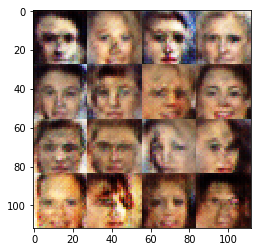

Epoch 0/1... Discriminator Loss: 0.7587... Generator Loss: 1.1285
Epoch 0/1... Discriminator Loss: 1.2594... Generator Loss: 1.4016
Epoch 0/1... Discriminator Loss: 1.2838... Generator Loss: 0.5270
Epoch 0/1... Discriminator Loss: 0.9869... Generator Loss: 0.7646
Epoch 0/1... Discriminator Loss: 1.0189... Generator Loss: 0.6920


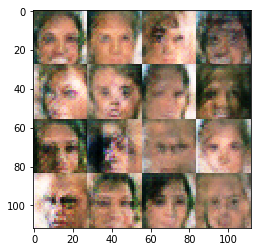

Epoch 0/1... Discriminator Loss: 0.9683... Generator Loss: 0.7562
Epoch 0/1... Discriminator Loss: 0.8737... Generator Loss: 1.1636
Epoch 0/1... Discriminator Loss: 0.9999... Generator Loss: 1.2180
Epoch 0/1... Discriminator Loss: 0.9174... Generator Loss: 0.8126
Epoch 0/1... Discriminator Loss: 1.3128... Generator Loss: 0.5484


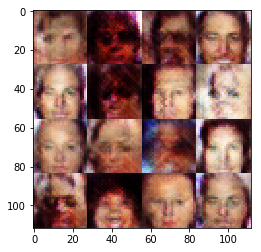

Epoch 0/1... Discriminator Loss: 1.0919... Generator Loss: 0.6952
Epoch 0/1... Discriminator Loss: 0.9120... Generator Loss: 0.7688
Epoch 0/1... Discriminator Loss: 1.6218... Generator Loss: 0.3383
Epoch 0/1... Discriminator Loss: 0.9087... Generator Loss: 1.3265
Epoch 0/1... Discriminator Loss: 1.0770... Generator Loss: 0.8705


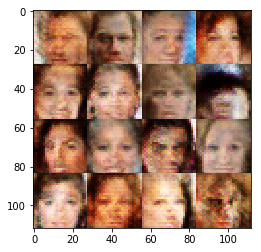

Epoch 0/1... Discriminator Loss: 0.9613... Generator Loss: 0.9341
Epoch 0/1... Discriminator Loss: 1.2872... Generator Loss: 0.7962
Epoch 0/1... Discriminator Loss: 0.9202... Generator Loss: 0.8932
Epoch 0/1... Discriminator Loss: 1.1342... Generator Loss: 0.9353
Epoch 0/1... Discriminator Loss: 1.0719... Generator Loss: 0.8389


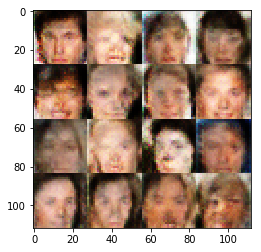

Epoch 0/1... Discriminator Loss: 0.9560... Generator Loss: 0.8845
Epoch 0/1... Discriminator Loss: 1.4170... Generator Loss: 0.6212
Epoch 0/1... Discriminator Loss: 1.0884... Generator Loss: 0.9204
Epoch 0/1... Discriminator Loss: 1.0520... Generator Loss: 0.7805
Epoch 0/1... Discriminator Loss: 0.9091... Generator Loss: 0.9123


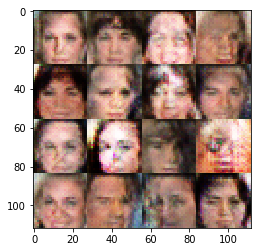

Epoch 0/1... Discriminator Loss: 0.8015... Generator Loss: 1.0280
Epoch 0/1... Discriminator Loss: 0.7790... Generator Loss: 0.9953
Epoch 0/1... Discriminator Loss: 1.1251... Generator Loss: 0.8629
Epoch 0/1... Discriminator Loss: 0.8617... Generator Loss: 1.2767
Epoch 0/1... Discriminator Loss: 0.9993... Generator Loss: 0.8803


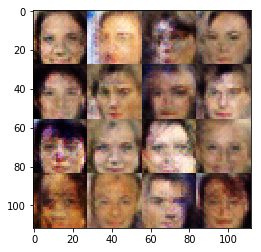

Epoch 0/1... Discriminator Loss: 0.9665... Generator Loss: 1.1770
Epoch 0/1... Discriminator Loss: 1.2787... Generator Loss: 0.5671
Epoch 0/1... Discriminator Loss: 1.2690... Generator Loss: 0.4278
Epoch 0/1... Discriminator Loss: 1.0655... Generator Loss: 0.7975
Epoch 0/1... Discriminator Loss: 1.2895... Generator Loss: 0.5878


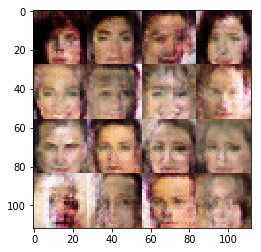

Epoch 0/1... Discriminator Loss: 0.9311... Generator Loss: 1.1233
Epoch 0/1... Discriminator Loss: 1.0818... Generator Loss: 0.6652
Epoch 0/1... Discriminator Loss: 1.3870... Generator Loss: 0.4482
Epoch 0/1... Discriminator Loss: 1.3377... Generator Loss: 0.4839
Epoch 0/1... Discriminator Loss: 0.8652... Generator Loss: 1.0667


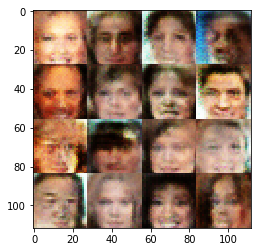

Epoch 0/1... Discriminator Loss: 1.0177... Generator Loss: 1.0857
Epoch 0/1... Discriminator Loss: 0.9415... Generator Loss: 1.3806
Epoch 0/1... Discriminator Loss: 1.0574... Generator Loss: 0.9773
Epoch 0/1... Discriminator Loss: 1.3072... Generator Loss: 0.5059
Epoch 0/1... Discriminator Loss: 1.1868... Generator Loss: 0.8324


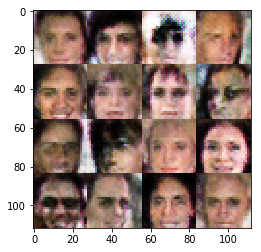

Epoch 0/1... Discriminator Loss: 0.9143... Generator Loss: 0.7281
Epoch 0/1... Discriminator Loss: 0.8539... Generator Loss: 0.8012
Epoch 0/1... Discriminator Loss: 1.0394... Generator Loss: 0.6397
Epoch 0/1... Discriminator Loss: 1.0631... Generator Loss: 0.7399
Epoch 0/1... Discriminator Loss: 1.0458... Generator Loss: 0.6698


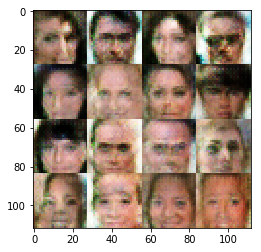

Epoch 0/1... Discriminator Loss: 1.1139... Generator Loss: 0.8094
Epoch 0/1... Discriminator Loss: 0.9930... Generator Loss: 1.0836
Epoch 0/1... Discriminator Loss: 1.0889... Generator Loss: 0.6941
Epoch 0/1... Discriminator Loss: 1.3893... Generator Loss: 0.4168
Epoch 0/1... Discriminator Loss: 1.4665... Generator Loss: 0.4173


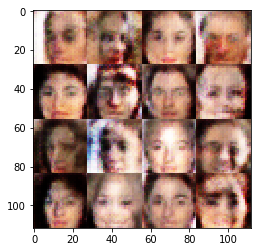

Epoch 0/1... Discriminator Loss: 1.2985... Generator Loss: 0.4882
Epoch 0/1... Discriminator Loss: 0.9602... Generator Loss: 1.0130
Epoch 0/1... Discriminator Loss: 0.9166... Generator Loss: 0.9165
Epoch 0/1... Discriminator Loss: 1.3044... Generator Loss: 0.4642
Epoch 0/1... Discriminator Loss: 0.8694... Generator Loss: 1.1604


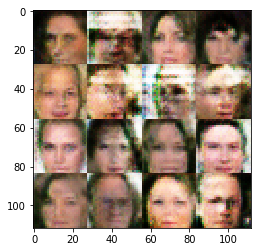

Epoch 0/1... Discriminator Loss: 1.0583... Generator Loss: 0.7728
Epoch 0/1... Discriminator Loss: 0.8849... Generator Loss: 1.1763
Epoch 0/1... Discriminator Loss: 0.9704... Generator Loss: 1.0088
Epoch 0/1... Discriminator Loss: 1.0979... Generator Loss: 0.7426
Epoch 0/1... Discriminator Loss: 1.0427... Generator Loss: 1.0534


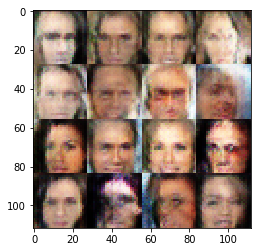

Epoch 0/1... Discriminator Loss: 0.9745... Generator Loss: 1.2687
Epoch 0/1... Discriminator Loss: 1.1033... Generator Loss: 0.6511
Epoch 0/1... Discriminator Loss: 0.9488... Generator Loss: 0.7527
Epoch 0/1... Discriminator Loss: 0.8654... Generator Loss: 0.8303
Epoch 0/1... Discriminator Loss: 1.2536... Generator Loss: 0.5099


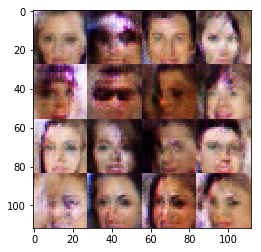

Epoch 0/1... Discriminator Loss: 1.0187... Generator Loss: 0.7594
Epoch 0/1... Discriminator Loss: 0.9431... Generator Loss: 1.0352
Epoch 0/1... Discriminator Loss: 1.3583... Generator Loss: 0.4648
Epoch 0/1... Discriminator Loss: 1.0864... Generator Loss: 1.2031
Epoch 0/1... Discriminator Loss: 1.0761... Generator Loss: 1.4719


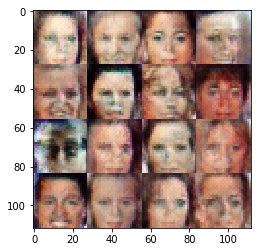

Epoch 0/1... Discriminator Loss: 1.0018... Generator Loss: 0.8882
Epoch 0/1... Discriminator Loss: 1.0930... Generator Loss: 0.7035
Epoch 0/1... Discriminator Loss: 1.1665... Generator Loss: 1.7210
Epoch 0/1... Discriminator Loss: 1.3332... Generator Loss: 0.5124
Epoch 0/1... Discriminator Loss: 1.1075... Generator Loss: 0.6799


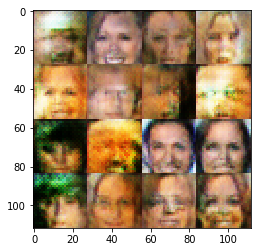

Epoch 0/1... Discriminator Loss: 1.0140... Generator Loss: 0.7169
Epoch 0/1... Discriminator Loss: 1.2677... Generator Loss: 0.9749
Epoch 0/1... Discriminator Loss: 1.0993... Generator Loss: 0.7026
Epoch 0/1... Discriminator Loss: 0.8670... Generator Loss: 1.0892
Epoch 0/1... Discriminator Loss: 1.0917... Generator Loss: 0.8357


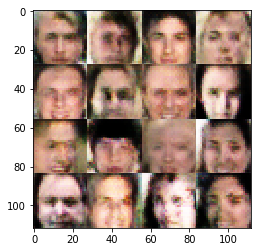

Epoch 0/1... Discriminator Loss: 1.0082... Generator Loss: 1.3465
Epoch 0/1... Discriminator Loss: 1.2814... Generator Loss: 0.5249
Epoch 0/1... Discriminator Loss: 1.0034... Generator Loss: 1.0952
Epoch 0/1... Discriminator Loss: 1.4110... Generator Loss: 0.4060
Epoch 0/1... Discriminator Loss: 1.1348... Generator Loss: 0.8204


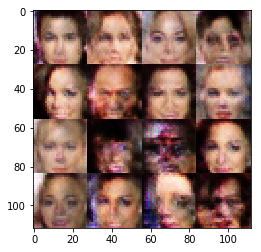

Epoch 0/1... Discriminator Loss: 1.1938... Generator Loss: 1.1915
Epoch 0/1... Discriminator Loss: 0.9033... Generator Loss: 0.8772
Epoch 0/1... Discriminator Loss: 1.0157... Generator Loss: 0.7918
Epoch 0/1... Discriminator Loss: 0.8921... Generator Loss: 0.8876
Epoch 0/1... Discriminator Loss: 0.8547... Generator Loss: 0.9340


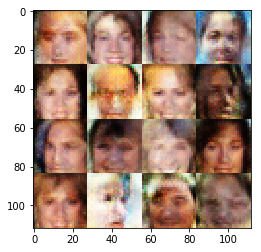

Epoch 0/1... Discriminator Loss: 1.0211... Generator Loss: 0.8088
Epoch 0/1... Discriminator Loss: 1.1046... Generator Loss: 0.7819
Epoch 0/1... Discriminator Loss: 0.7562... Generator Loss: 1.2925
Epoch 0/1... Discriminator Loss: 1.3962... Generator Loss: 0.7327
Epoch 0/1... Discriminator Loss: 0.9592... Generator Loss: 1.3016


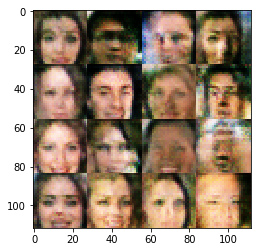

Epoch 0/1... Discriminator Loss: 1.2784... Generator Loss: 0.5335
Epoch 0/1... Discriminator Loss: 0.9127... Generator Loss: 0.8369
Epoch 0/1... Discriminator Loss: 1.1349... Generator Loss: 0.6926
Epoch 0/1... Discriminator Loss: 0.6878... Generator Loss: 1.2331
Epoch 0/1... Discriminator Loss: 0.9995... Generator Loss: 0.8485


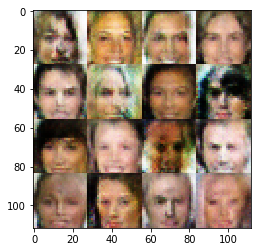

Epoch 0/1... Discriminator Loss: 1.0862... Generator Loss: 0.8800
Epoch 0/1... Discriminator Loss: 1.0262... Generator Loss: 0.9191
Epoch 0/1... Discriminator Loss: 1.1313... Generator Loss: 0.5787
Epoch 0/1... Discriminator Loss: 1.5149... Generator Loss: 0.3471
Epoch 0/1... Discriminator Loss: 1.1278... Generator Loss: 0.6306


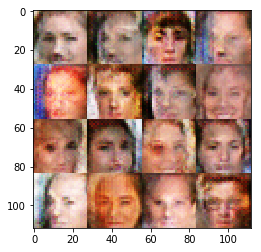

Epoch 0/1... Discriminator Loss: 1.1239... Generator Loss: 0.7482
Epoch 0/1... Discriminator Loss: 1.1860... Generator Loss: 0.5306
Epoch 0/1... Discriminator Loss: 0.9232... Generator Loss: 0.9397
Epoch 0/1... Discriminator Loss: 0.9451... Generator Loss: 0.8371
Epoch 0/1... Discriminator Loss: 1.3830... Generator Loss: 0.5015


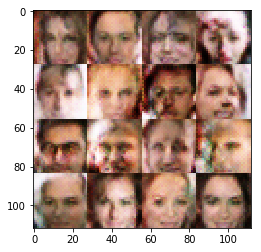

Epoch 0/1... Discriminator Loss: 1.0823... Generator Loss: 0.8429
Epoch 0/1... Discriminator Loss: 0.9787... Generator Loss: 0.8648
Epoch 0/1... Discriminator Loss: 1.1303... Generator Loss: 0.7286
Epoch 0/1... Discriminator Loss: 1.3138... Generator Loss: 0.5444
Epoch 0/1... Discriminator Loss: 1.3195... Generator Loss: 0.5147


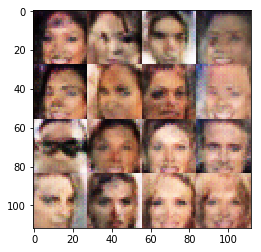

Epoch 0/1... Discriminator Loss: 1.1354... Generator Loss: 0.8378
Epoch 0/1... Discriminator Loss: 0.8870... Generator Loss: 0.8828
Epoch 0/1... Discriminator Loss: 0.6724... Generator Loss: 1.2980
Epoch 0/1... Discriminator Loss: 1.0986... Generator Loss: 0.8441
Epoch 0/1... Discriminator Loss: 1.0590... Generator Loss: 0.8021


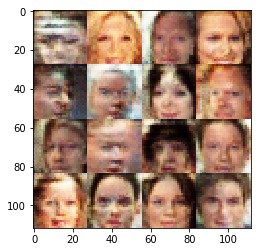

Epoch 0/1... Discriminator Loss: 1.3126... Generator Loss: 0.7564
Epoch 0/1... Discriminator Loss: 1.1498... Generator Loss: 0.7505


In [35]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.